In [1]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
os.chdir("D:\\Documents\\Lambda")
df = pd.read_csv("sharkattack.csv")

In [2]:
df.head()

,Unnamed: 0,Date,Country,Country code,Type,Continent,Hemisphere,Activity,Fatal
0,0,2/11/2017,United States,US,Unprovoked,North America,N,Swimming,N
1,1,2/6/2017,Brazil,BR,Provoked,South America,S,Other,N
2,2,2/6/2017,South Africa,ZA,Boat,Africa,S,Fishing,N
3,3,2/1/2017,United States,US,Boat,North America,N,Other,N
4,4,2/1/2017,Bahamas,BS,Unprovoked,North America,N,Diving,N


In [5]:
%%time
df.profile_report()

Wall time: 28.6 s


In [3]:
df["Fatal"].value_counts(normalize = True)

N          0.741800
Y          0.242711
UNKNOWN    0.015488
Name: Fatal, dtype: float64

In [4]:
df = df[df.Fatal != "UNKNOWN"]

In [5]:
df["Fatal"] = df["Fatal"].str.contains("Y")


In [6]:
# baseline score
df["Fatal"].value_counts(normalize = True)

False    0.75347
True     0.24653
Name: Fatal, dtype: float64

In [7]:
df.isnull().sum()

Unnamed: 0        0
Date              0
Country           0
Country code    160
Type              0
Continent       158
Hemisphere       32
Activity          0
Fatal             0
dtype: int64

In [8]:
df = df.fillna(method = "ffill")

In [9]:
df.isnull().sum()

Unnamed: 0      0
Date            0
Country         0
Country code    0
Type            0
Continent       0
Hemisphere      0
Activity        0
Fatal           0
dtype: int64

In [10]:
df = df.drop(["Date","Unnamed: 0"],axis =1)

In [11]:
#df["Date"] = pd.to_datetime(df["Date"])

In [12]:
from sklearn.model_selection import train_test_split
# get train set and test set
train,test = train_test_split(df,train_size = .5,test_size = .5,random_state = 42)

In [13]:
# get train set and validation set
train,val = train_test_split(train,train_size = .8,test_size = .2,random_state = 42)

In [14]:
target = "Fatal"
X_train = train.drop(target,axis = 1)
y_train = train[target]
X_val = val.drop(target,axis = 1)
y_val = val[target]
X_test = test.drop(target,axis = 1)
y_test = test[target]


In [15]:
X_train.head()

,Country,Country code,Type,Continent,Hemisphere,Activity
5064,Australia,AU,Unprovoked,Australia,S,Other
5075,Bahamas,BS,Unprovoked,North America,N,Other
3688,United States,US,Unprovoked,North America,N,Swimming
759,Australia,AU,Provoked,Australia,S,Fishing
4405,Australia,AU,Unprovoked,Australia,S,Swimming


In [16]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [17]:
pipe = make_pipeline(ce.OrdinalEncoder(),
                     SimpleImputer(strategy = "mean"), # dont really need this but adding it anyway
                     RandomForestClassifier(n_estimators=1000, n_jobs = -1,random_state=42))

In [18]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Country', 'Country code', 'Type',
                                      'Continent', 'Hemisphere', 'Activity'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Country',
                                          'data_type': dtype('O'),
                                          'mapping': Australia                         1
Bahamas                           2
United States                     3
North Pacific Ocean               4
Solomon Islands                   5
Papua New Guinea                  6
Croatia                           7
So...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
          

In [19]:
y_pred = pipe.predict(X_test)
accuracy_score(y_test,y_pred)

0.764618800888231

In [20]:
from sklearn.metrics import roc_auc_score
y_pred_prob = pipe.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.782333450621628

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from sklearn.metrics import classification_report

In [22]:
confusion_matrix(y_test,y_pred)

array([[1825,  205],
       [ 431,  241]], dtype=int64)

In [23]:
def plotCM(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

In [24]:
plotCM(y_test,y_pred)

,Predicted False,Predicted True
Actual False,1825,205
Actual True,431,241


In [25]:
table = plotCM(y_test,y_pred)

In [26]:
def plotHM(table):
    sns.heatmap(table,annot = True,fmt = "d",cmap = "viridis");

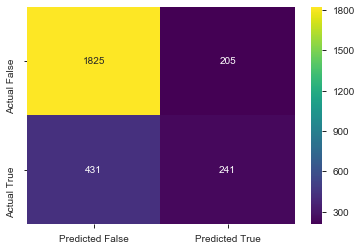

In [27]:
plotHM(table)

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.81      0.90      0.85      2030
        True       0.54      0.36      0.43       672

    accuracy                           0.76      2702
   macro avg       0.67      0.63      0.64      2702
weighted avg       0.74      0.76      0.75      2702



In [29]:
rf = pipe.named_steps["randomforestclassifier"]
importances = pd.Series(rf.feature_importances_,X_train.columns)

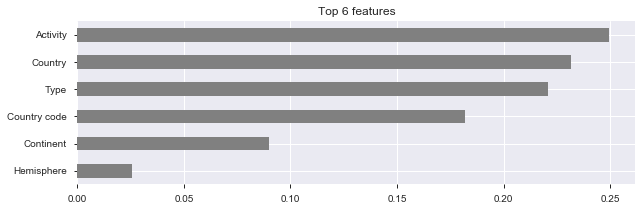

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

n = 6
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [31]:
trans = make_pipeline(ce.OrdinalEncoder(),
                      SimpleImputer(strategy = "mean"))

X_train_trans = trans.fit_transform(X_train)
X_val_trans = trans.transform(X_val)

model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
model.fit(X_train_trans,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model,scoring = "accuracy",
                                 n_iter = 2,
                                 random_state = 42)

permuter.fit(X_val_trans,y_val)
features = X_val.columns.tolist()

eli5.show_weights(permuter,top = None,feature_names = features)

Weight,Feature
0.0379 ± 0.0129,Type
0.0370 ± 0.0037,Activity
0.0009 ± 0.0018,Hemisphere
0.0009 ± 0.0055,Country code
-0.0028 ± 0.0314,Country
-0.0083 ± 0.0018,Continent
